Load Libraries

In [1]:
import numpy as np
import pandas as pd
import os.path as op
import spacy
nlp = spacy.load('en')

Load Data

In [2]:
DATA_PROCESSED = '../data/processed'

In [3]:
labeled = pd.read_csv(op.join(DATA_PROCESSED, 'labeled_projects.csv'))
all_projects = pd.read_csv(op.join(DATA_PROCESSED, 'cancer_projects_full.csv'))

# Simpson's Index of Diversity

In [ ]:
kw = np.array([1,1,1])

tot = sum(kw * (kw-1))
print(1 - tot / (sum(kw) * (sum(kw) - 1)))

kw = np.array([1,0,1])

tot = sum(kw * (kw-1))
print(1 - tot / (sum(kw) * (sum(kw) - 1)))

In [ ]:
# will create a dataframe with project ID, and measures of productivity for battle and journey
productivities = []

# group by id
for i, g in labeled.groupby('project_id'):
    # get the number of words total for the project text
    all_words = all_projects.loc[all_projects['id'] == i, 'text_length_words']
    
    # some (~20) projects don't have data on text body size... potential bug
    if all_words.size > 0 and all_words.values[0] > 0:
        
        # battle productivity
        kw = g.loc[g['type'] == 'battle', 'keyword'].value_counts().values
#         kw = np.append(kw, all_words.values[0])

        # compute Simpson's Index of Diversity
        #     sum n(n - 1) 
        tot = sum(kw * (kw-1))
        if sum(kw) > 0:
            battle_div = tot / (sum(kw) * (sum(kw) - 1))
        else:
            battle_div = 0.0
        
        # journey productivity
        kw = g.loc[g['type'] == 'journey', 'keyword'].value_counts().values
#         kw = np.append(kw, all_words.values[0])

        # compute Simpson's Index of Diversity
        tot = sum(kw * (kw-1))
        if sum(kw) > 0:
            journey_div = tot / (sum(kw) * (sum(kw) - 1))
        else:
            journey_div = 0.0
        
    else:
        battle_div, journey_div = 0.0, 0.0
        
    productivities.append([i, battle_div, journey_div])
    
productivities = pd.DataFrame(productivities, columns=['id', 'battle_prod', 'journey_prod'])

Top projects by productivity, after looking at the text of these projects, the measure seems like an accurate representation of diversity in metaphor instantiation.

In [ ]:
productivities.nlargest(10, 'battle_prod')

An example project:

In [ ]:
all_projects.loc[all_projects['id'] == 1665364667, :]

In [ ]:
labeled.loc[labeled['project_id'] == 1665364667]

Create a copy (so as to not affect the original) and merge

In [ ]:
all_projects_c = all_projects.copy(deep=True)

In [ ]:
all_projects_c = all_projects_c.merge(productivities, how='left', on='id', validate='one_to_one')

It looks like our measures of diversity are highly correlated with salience:

In [ ]:
np.corrcoef(all_projects_c[['battle_prod', 'journey_prod', 'battle_salience', 'journey_salience']], rowvar=False)

# Custom Productivity

Let $C$ be the set of keyword counts over all projects. Each keyword appears $C_i \gt 0$ times, such that $i=1, 2, ..., N$ where $N$ is the number of unique keywords in the corpus.

Let $W$ be the set of keyword counts for a given project, where $W_i \geq 0$ for $i=1, 2, ..., N$. $C_i$ and $W_i$ represent the same keyword.

Productivity for a given keyword family of a given project is:
$$
P_{\text{family}} = \sum_{i=1}^N W_i \times \big(\frac{\sum_{k=1}^N C_k}{C_i}\big)^r
$$
where $r$ is some proportionality constant.

In the following work, $r=0.4$ because this results in the least frequent word, *beats*, becoming the "equivalent" (in terms of how creative we perceive its usage) to about 6 usages of the most frequent word, *fight*. This number is partially arbitrary and can be changed as seen fit. The frequency proportion (the value raised to $r$) is divided by the minimum of the set of frequency proportions, thereby forcing the most frequent word to have a frequency proportion of 1.0.



In [4]:
battle_vc = labeled.dropna().loc[labeled['type'] == 'battle', 'keyword'].value_counts()
journey_vc = labeled.dropna().loc[labeled['type'] == 'journey', 'keyword'].value_counts()

print(battle_vc)

r = 0.4

battle_freq_map = (sum(battle_vc) / battle_vc) ** r
battle_freq_map = dict(battle_freq_map / min(battle_freq_map))

journey_freq_map = (sum(journey_vc) / journey_vc) ** r
journey_freq_map = dict(journey_freq_map / min(journey_freq_map))


print(sum(battle_vc))
battle_freq_map

fight       79
fighting    59
battle      55
battling    27
beat        11
fought       9
battled      6
war          4
beating      4
fights       4
battles      4
enemy        3
beaten       2
beats        1
brutal       1
Name: keyword, dtype: int64
269


{'fight': 1.0,
 'fighting': 1.1238543524724893,
 'battle': 1.1558614000295084,
 'battling': 1.536403652173812,
 'beat': 2.200360106775823,
 'fought': 2.3842612073733243,
 'battled': 2.804079590211117,
 'war': 3.2978191835368778,
 'beating': 3.2978191835368778,
 'fights': 3.2978191835368778,
 'battles': 3.2978191835368778,
 'enemy': 3.700005201720385,
 'beaten': 4.351498500975518,
 'beats': 5.7418366957535865,
 'brutal': 5.7418366957535865}

In [5]:
# will create a dataframe with project ID, and measures of productivity for battle and journey
productivities = []

# group by id
for i, g in labeled.groupby('project_id'):
    # get the number of words total for the project text
    all_words = all_projects.loc[all_projects['id'] == i, 'text_length_words']
    
    # some (~20) projects don't have data on text body size... potential bug
    if all_words.size > 0 and all_words.values[0] > 0:
        
        kw = g.loc[g['type'] == 'battle', 'keyword'].value_counts()
        s = [battle_freq_map[k] * kw[k] for k in dict(kw)]
        battle_div = sum(s)
        
        kw = g.loc[g['type'] == 'journey', 'keyword'].value_counts()
        s = [journey_freq_map[k] * kw[k] for k in dict(kw)]
        journey_div = sum(s)
        
    else:
        battle_div, journey_div = 0.0, 0.0
        
    productivities.append([i, battle_div, journey_div])
    
productivities = pd.DataFrame(productivities, columns=['id', 'battle_prod', 'journey_prod'])

In [6]:
all_projects_c = all_projects.copy(deep=True)
all_projects_c = all_projects_c.merge(productivities, how='left', on='id', validate='one_to_one')

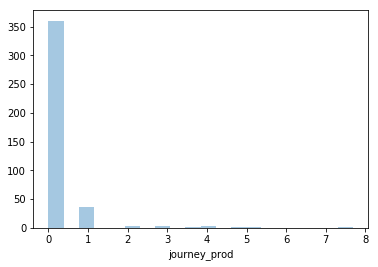

In [8]:
import seaborn as sns
sns.distplot(all_projects_c['journey_prod'], kde=False)

In [9]:
all_projects_c.loc[all_projects_c['battle_prod'] < 5].shape

(391, 50)

In [11]:
all_projects_c.nlargest(6, 'battle_prod')

,id,name,blurb,created,launched,deadline,goal,spotlight,staff_pick,status,...,journey_salience,battle_productivity,journey_productivity,dominant_battle,dominant_journey,dominant_both,dominant_neither,dominant,battle_prod,journey_prod
26,134281058,THE BOOK OF HEALERS HEALING: AN ODYSSEY THROUG...,"Combining narrative, poetry & interviews with ...",1380120239,1381249864,1384060320,5000,True,False,1,...,0.0,1.000000,0.0,1,0,0,0,Battle,18.481498,0.0
3,1665364667,A Recipe for Hope,Our family's journey living with and fighting ...,1470688455,1473253802,1475845802,5500,True,False,1,...,0.0,0.625000,0.0,1,0,0,0,Battle,17.155542,0.0
78,238840799,THE KNOCKOUT,For our KNOCKOUT Breast Cancer Photo Shoot eve...,1396740076,1406927542,1412111542,5000,True,False,1,...,0.0,0.500000,0.0,1,0,0,0,Battle,9.900365,0.0
33,1490542747,Whatever Happened to Patient 2410,The inspiring autobiography of the late Minda ...,1385095833,1409332843,1411924843,6000,True,True,1,...,0.0,0.666667,0.0,1,0,0,0,Battle,9.399718,0.0
158,8143920,Music for cancer Fighters,My mother is a cancer survivor I seen her pain...,1455843485,1484560151,1487152151,2500,False,False,0,...,0.0,0.500000,0.0,1,0,0,0,Battle,7.879679,0.0
42,481532678,Always Live Laugh Love Featured Film,Featured Film nearly completed 10 % of this fi...,1471127729,1471144844,1475032844,5000,False,False,0,...,0.0,1.000000,0.0,1,0,0,0,Battle,7.708476,0.0


In [12]:
labeled.loc[labeled['project_id'] == 134281058]

,project_id,fragment,char_location,type,keyword
91,134281058,"r eyes, whisper, horrible.Others\nlaugh, give ...",5399.0,battle,beating
92,134281058,ngratulate me on beating ovarian cancer.I don'...,5462.0,battle,beats
642,134281058,"me a high five, congratulate me on beating ov...",5443.0,battle,enemy
643,134281058,y a world-renowned ovarian cancer expert for t...,879.0,battle,brutal
